# Preface

In [189]:
# IMPORTS
import os
import string
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from collections import Counter
plt.style.use("ggplot")
%matplotlib inline

# Task 5.1: News Article - Preprocessing


In a first step, we are going to process news articles in order to try to apply clustering algorithms. The news article corpus-30docs includes 30 news articles from the domains of science, religion and politics (10 documents for each domain). Import the documents into your process and vectorize them using stopword removal and stemming (Porter). If necessary, transform all tokens to their lower cased version. How large are the resulting document vectors?

In [2]:
# Prep work
data_dir = "../data/"
doc_dirs = ["sci.space", "soc.religion.christian", "talk.politics.guns"]
doc_paths = []

# Get a list of all (relative) filepaths
for d in doc_dirs:
    for f in os.listdir(os.path.join(data_dir, d)):
        doc_paths.append(os.path.join(data_dir, d, f))
    
# Create a custom Porter Stemmer that suits sklearn
class PortStem(object):
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        return [self.ps.stem(word) for word in word_tokenize(doc)]

# Initiate a new vectorizer
vectorizer = CountVectorizer(input="filename",
                             stop_words="english", 
                             tokenizer=PortStem())

# creating the bag of words
bow = vectorizer.fit_transform(doc_paths)

# evaluate num of features
print(bow.shape)

(30, 3027)


The resulting Dataframe has **3027** attributes identified. Unfortunately the combination of `PorterStemmer()` and `word_tokenize` did not remove punctuation or numbers. Therefore a more advanced Tokenizer shall be used that:
1. replaces punctuation and numbers to blanks
2. stems based on the Porter algorithm

In [3]:
# Create a more advanced tokenizer
class PortStemNoPunctNum(object):
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        return [self.ps.stem(word)
                for word 
                in word_tokenize(
                doc.translate(
                    str.maketrans(string.punctuation + "0123456789",' '*len(string.punctuation + "0123456789"))))]
    
# Initiate a new (advanced) vectorizer
vectorizer_adv = CountVectorizer(input="filename",
                                 stop_words="english",
                                 tokenizer=PortStemNoPunctNum())

# creating the bag of words
bow_adv = vectorizer_adv.fit_transform(doc_paths)

# evaluate num of features
print(bow_adv.shape)

(30, 2588)


The new Bag-of-Words only contains features without punctuation(`!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~`) and numbers. **The overall number of features is 2588 features**

---
# Task 5.2: News Article - Clustering
Having imported the documents and transformed them into vectors, apply a k-means clustering using k = 3. How many documents ended up in the wrong cluster? What can you do to improve the clustering? 

In [201]:
# generating a TF-IDF 
tfidf_trans = TfidfTransformer()
tfidf = tfidf_trans.fit_transform(bow_adv)

# Initating, fitting the k-means learner & predicting
km3 = KMeans(n_clusters=3, random_state=42)
y_pred = km3.fit_predict(tfidf)
y_pred.reshape(3, 10)

array([[1, 2, 2, 2, 2, 2, 2, 1, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 1, 2, 2, 2, 2, 2, 2, 1]], dtype=int32)

All the samples from the religion domain are put in the "right" cluster whereas k-means fails for the scientific and politcal cluster. Independent from assigning a 1 or a 2 to either one of the clusters one cluster has the "accuracy" of 80% and the other an "accuracy" of 20%.

In [211]:
# Compare to clustering based on raw tf
y_pred_tf = km3.fit_predict(bow_adv)
y_pred_tf.reshape(3, 10)

array([[2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

Clustering on the raw term frequency leads to an overall decrease of accuracy.

---
# Task 5.3: News Article - Improved Clustering
Does the distribution of frequent terms help you to further improve the clustering by using any of the prune methods of the Process Documents from File operator?

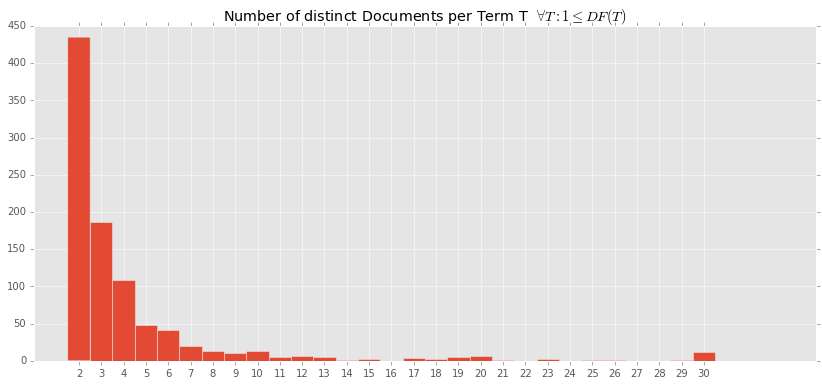

In [389]:
# Create new word vectorizer that stores '1' for non-zero TFs
binary_vectorizer = CountVectorizer(input="filename",
                                    stop_words="english",
                                    tokenizer=PortStemNoPunctNum(),
                                    binary=True
                                   )
# create binary bag-of-words 
bin_tf = binary_vectorizer.fit_transform(doc_paths)

df_min_2 = np.apply_along_axis(np.sum, axis=0, arr=bin_tf.toarray())[
    np.apply_along_axis(np.sum, axis=0, arr=bin_tf.toarray()) > 1
]

# evaluate document frequency for words that occur more than once
plt.rcParams["figure.figsize"] = [14, 6]
d = np.diff(np.unique(df_min_2)).min()
left_of_first_bin = df_min_2.min() - float(d)/2
right_of_last_bin = df_min_2.max() + float(d)/2
plt.hist(df_min_2, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(range(np.min(df_min_2), np.max(df_min_2)+1))
plt.title("Number of distinct Documents per Term T  $ \\forall T: 1\leq DF(T) $ ")
plt.savefig("../figures/textmining/distinct-documents-per-term.png")
plt.show()

As the histogram shows the majority of terms are only present in two distinct documents. One could try to limit the number of DF into a certain range - cutting of the domain specific stopwords as well as very common words.

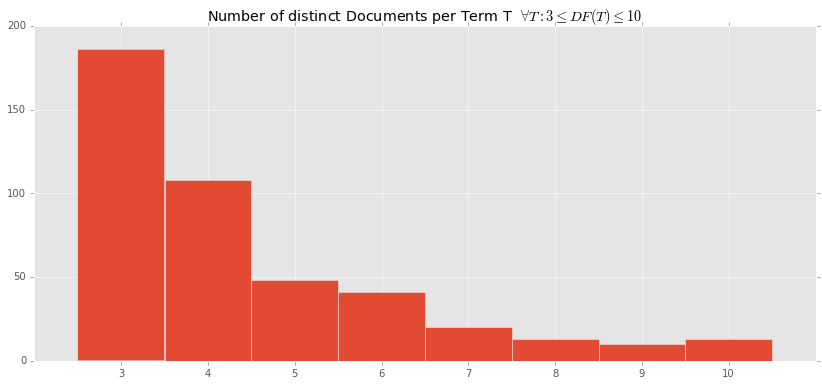

In [390]:
# Create new word vectorizer that preprunes terms 
# that occur in less than 4 or more than 10 documents
bin_vectorizer_pruned = CountVectorizer(input="filename",
                                        stop_words="english",
                                        tokenizer=PortStemNoPunctNum(),
                                        min_df = 3,
                                        max_df = 10,
                                        binary = True
                                        )

# create binary bag-of-words 
bin_tf = bin_vectorizer_pruned.fit_transform(doc_paths)

df_3_to_10 = np.apply_along_axis(np.sum, axis=0, arr=bin_tf.toarray())

# evaluate document frequency for words that occur more than once
plt.rcParams["figure.figsize"] = [14, 6]
d = np.diff(np.unique(df_3_to_10)).min()
left_of_first_bin = df_3_to_10.min() - float(d)/2
right_of_last_bin = df_3_to_10.max() + float(d)/2
plt.hist(df_3_to_10, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(range(np.min(df_3_to_10), np.max(df_3_to_10)+1))
plt.title("Number of distinct Documents per Term T  $ \\forall T: 3 \leq DF(T) \leq 10$ ")
plt.savefig("../figures/textmining/distinct-documents-per-term-pruned.png")
plt.show()

In [404]:
vectorizer_pruned = CountVectorizer(input="filename",
                                    stop_words="english",
                                    tokenizer=PortStemNoPunctNum(),
                                    min_df = 3,
                                    max_df = 10
                                   )

# create a bag of words (TF) on pruned vectorizer
bow_tf_pruned = vectorizer_pruned.fit_transform(doc_paths)

# create a bag of words (TF-IDF) on pruned vectorizer
bow_tfidf_pruned = tfidf_trans.fit_transform(bow_tf_pruned)

# Compare to clustering based on raw tf
y_pred_df_pruned_tf = km3.fit_predict(bow_tf_pruned)
y_pred_df_pruned_tfidf = km3.fit_predict(bow_tfidf_pruned)

# Evaluate clustering after pruning
print("TF:\n{}\n\nTFIDF:\n{}"
      .format(y_pred_df_pruned_tf.reshape((3,10)), y_pred_df_pruned_tfidf.reshape((3, 10))))

TF:
[[2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]

TFIDF:
[[2 2 1 2 2 2 2 2 1 2]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]]


**Pruning to a document frequency in the range of 3 to 10 and calculating the TFIDF improves the clustering significantly**. The overall "accuracy" of the clustering is around 93% (2 out of 30 articles are misclassified).

---
# Task 5.4: Job Postings: Preprocessing

In a second step, we will focus on the classification of job postings. The jobpostings.xls  file contains 500 descriptions of job postings belonging to 30 different job categories like sales and real estate. Our main goal is to learn a classification model, which is capable to predict the correct category for a new job posting. Therefore, import the data into RapidMiner using the Read Excel and the Process Document from Data operators. Convert the textual description into a vector by applying tokenization and other preprocessing steps. In order to learn a good classification model, have a look at the generated attributes and basic setup for the preprocessing which removes noisy and misleading tokens.


# Task 5.5: Job Postings - Classification
What levels of accuracy can you reach applying different classification methods and preprocessing settings?

## Preprocessing

In [4]:
# Load the data
df_jobs = pd.read_excel("../data/JobPostings.xls")
job_desc = df_jobs["JobText"].values
job_cat = df_jobs["Category"].values

In [7]:
# get an overview about distribution of categories
Counter(job_cat)

Counter({'accounting/finance': 14,
         'admin/office': 24,
         'architect/engineer/CAD': 4,
         'art/media/design': 10,
         'business/mgmt': 3,
         'customer service': 18,
         'education/teaching': 18,
         'et cetera': 4,
         'food/beverage/hospitality': 61,
         'general labor': 45,
         'healthcare': 30,
         'human resource': 3,
         'internet engineering': 1,
         'legal/paralegal': 3,
         'manufacturing': 8,
         'marketing/advertising/PR': 13,
         'nonprofit': 13,
         'real estate': 7,
         'retail/wholesale': 25,
         'sales': 47,
         'salon/spa/fitness': 23,
         'security': 6,
         'skilled trades/artisan': 48,
         'software/QA/DBA/etc': 25,
         'systems/networking': 3,
         'technical support': 6,
         'transportation': 18,
         'tv/film/video/radio': 8,
         'web/HTML/info design': 6,
         'writing/editing': 5})

Since the category **`internet engineering`** only occurs one, it can not be used for supervised learning and is therefore ommitted from the dataset.

In [ ]:
df_jobs = df_jobs.drop(df_jobs[
        df_jobs["Category"] == "internet engineering"
    ].index)
job_desc = df_jobs["JobText"].values
job_cat = df_jobs["Category"].values

## Naive Bayes

In [56]:
# NAIVE-BAYES classification pipeline
pl_clf_jobs = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PortStemNoPunctNum())),
                        ('clf', MultinomialNB()),
                       ])

# Parameter grid for hyper parameter tuning (of preprocessing)
param_grid = [{'tfidf__stop_words' : [None, 'english'],
               'tfidf__strip_accents' : [None, 'ascii', 'unicode'],
               'tfidf__tokenizer' : [None, PortStem(), PortStemNoPunctNum()]
              }]

# create grid search
gs_clf_jobs = GridSearchCV(pl_clf_jobs,
                           param_grid=param_grid,
                           cv=10,
                           n_jobs=-1,
                           verbose=True
                          )

# run grid search
_ = gs_clf_jobs.fit(job_desc, job_cat)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


/Users/joshuagorner/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


In [65]:
# Retrieving information about the best model
nb_score = pd.DataFrame(gs_clf_jobs.cv_results_).iloc[gs_clf_jobs.best_index_, :]["mean_test_score"]
print("Naive Bayes reaches a 10 fold CV score of {}".format(nb_score))

Naive Bayes reaches a 10 fold CV score of 0.30522088353413657


## KNN 
<span style="color:#AAAAAA">Due to computationally expensiveness the parameter `stop_words`, `strip_accents` and `tokenizer` are preset</span>

In [186]:
# KNN classification pipeline
pl_clf_jobs_knn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PortStemNoPunctNum())),
                        ('clf', KNeighborsClassifier()),
                       ])

# Parameter grid for hyper parameter tuning 
param_grid_knn = [{'tfidf__stop_words' : ['english'],
                   'tfidf__strip_accents' : ['ascii'],
                   'tfidf__tokenizer' : [PortStemNoPunctNum()],
                   'tfidf__ngram_range' : [(1,1), (2,2), (3,3), (4,4)],
                   'clf__n_neighbors' : [1,5,6,7],
                   'clf__metric' : ['cosine']
                  }]

# create grid search
gs_clf_jobs_knn = GridSearchCV(pl_clf_jobs_knn,
                               param_grid=param_grid_knn,
                               cv=10,
                               n_jobs=-1,
                               verbose=True
                              )

# run grid search
_ = gs_clf_jobs_knn.fit(job_desc, job_cat)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/Users/joshuagorner/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.3min finished


In [187]:
# Retrieving information about the best model
knn_score = pd.DataFrame(gs_clf_jobs_knn.cv_results_).iloc[gs_clf_jobs_knn.best_index_, :]["mean_test_score"]
print("K Nearest Neighbor reaches a 10 fold CV score of {}".format(knn_score))

K Nearest Neighbor reaches a 10 fold CV score of 0.4779116465863454


## Decision Tree
<span style="color:#AAAAAA">Due to computationally expensiveness the parameter `stop_words` is preset</span>

In [90]:
# Decision Tree classification pipeline
pl_clf_jobs_dt = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PortStemNoPunctNum())),
                           ('clf', DecisionTreeClassifier()),
                          ])

# Parameter grid for hyper parameter tuning 
param_grid_dt = [{'tfidf__stop_words' : ['english'],
                  'tfidf__strip_accents' : [None, 'ascii', 'unicode'],
                  'tfidf__tokenizer' : [None, PortStem(), PortStemNoPunctNum()],
                  'clf__max_depth' : [10, 15, 20, 25, 30, 35, 40, 45, 50]
                 }]

# create grid search
gs_clf_jobs_dt = GridSearchCV(pl_clf_jobs_dt,
                              param_grid=param_grid_dt,
                              cv=10,
                              n_jobs=-1,
                              verbose=True
                              )

# run grid search
_ = gs_clf_jobs_dt.fit(job_desc, job_cat)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


/Users/joshuagorner/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  6.1min finished


In [93]:
# Retrieving information about the best model
dt_score = pd.DataFrame(gs_clf_jobs_dt.cv_results_).iloc[gs_clf_jobs_dt.best_index_, :]["mean_test_score"]
print("Decision Tree Classifier reaches a 10 fold CV score of {}".format(dt_score))

Decision Tree Classifier reaches a 10 fold CV score of 0.39759036144578314


## Logistic Regression

In [142]:
# Logistic Regression classification pipeline
pl_clf_jobs_lr = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PortStemNoPunctNum())),
                           ('clf', LogisticRegression()),
                          ])

# Parameter grid for hyper parameter tuning 
param_grid_lr = [{'tfidf__stop_words' : [None, 'english'],
                  'tfidf__strip_accents' : [None, 'ascii'],
                  'tfidf__tokenizer' : [None, PortStemNoPunctNum()],
                  'clf__penalty' : ["l1", "l2"],
                  'clf__C' : [1.0, 10.0, 100.0,]
                 }]

# create grid search
gs_clf_jobs_lr = GridSearchCV(pl_clf_jobs_lr,
                              param_grid=param_grid_lr,
                              cv=10,
                              n_jobs=-1,
                              verbose=True
                              )

# run grid search
_ = gs_clf_jobs_lr.fit(job_desc, job_cat)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/Users/joshuagorner/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.9min finished


In [143]:
# Retrieving information about the best model
lr_score = pd.DataFrame(gs_clf_jobs_lr.cv_results_).iloc[gs_clf_jobs_lr.best_index_, :]["mean_test_score"]
print("Logistic Regression Classifier reaches a 10 fold CV score of {}".format(lr_score))

Logistic Regression Classifier reaches a 10 fold CV score of 0.6144578313253012


## Support Vector Machines

In [180]:
# SVM classification pipeline
pl_clf_jobs_svm = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PortStemNoPunctNum())),
                            ('clf', SVC()),
                           ])

# Parameter grid for hyper parameter tuning 
param_grid_svm = [{'tfidf__stop_words' : [None, 'english'],
                   'tfidf__strip_accents' : [None, 'ascii'],
                   'tfidf__tokenizer' : [None, PortStemNoPunctNum()],
                   'clf__gamma' : [1.0/64, 2.0/64, 3.0/64],
                   'clf__C' : [10.0, 100.0, 1000.0]
                  }]

# create grid search
gs_clf_jobs_svm = GridSearchCV(pl_clf_jobs_svm,
                               param_grid=param_grid_svm,
                               cv=10,
                               n_jobs=-1,
                               verbose=True
                              )

# run grid search
_ = gs_clf_jobs_svm.fit(job_desc, job_cat)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/Users/joshuagorner/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.2min finished


In [183]:
# Retrieving information about the best model
svm_score = pd.DataFrame(gs_clf_jobs_svm.cv_results_).iloc[gs_clf_jobs_svm.best_index_, :]["mean_test_score"]
print("SVM Classifier reaches a 10 fold CV score of {}".format(svm_score))

SVM Classifier reaches a 10 fold CV score of 0.5481927710843374


## Classification Results

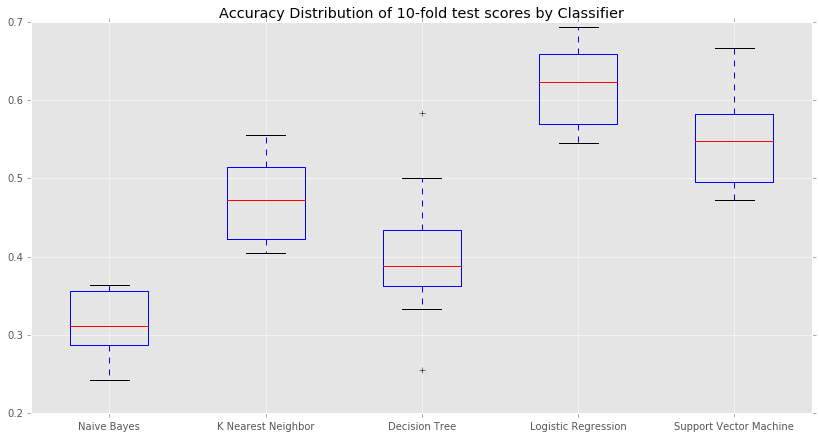

In [256]:
# to be refactored:
test_cols = ["split0_test_score",
             "split1_test_score",
             "split2_test_score",
             "split3_test_score",
             "split4_test_score",
             "split5_test_score",
             "split6_test_score",
             "split7_test_score",
             "split8_test_score",
             "split9_test_score"]

test_nb = pd.DataFrame(gs_clf_jobs.cv_results_).ix[gs_clf_jobs.best_index_, test_cols].values.astype(float)
test_knn = pd.DataFrame(gs_clf_jobs_knn.cv_results_).ix[gs_clf_jobs_knn.best_index_, test_cols].values.astype(float)
test_dt = pd.DataFrame(gs_clf_jobs_dt.cv_results_).ix[gs_clf_jobs_dt.best_index_, test_cols].values.astype(float)
test_lr = pd.DataFrame(gs_clf_jobs_lr.cv_results_).ix[gs_clf_jobs_lr.best_index_, test_cols].values.astype(float)
test_svm = pd.DataFrame(gs_clf_jobs_svm.cv_results_).ix[gs_clf_jobs_svm.best_index_, test_cols].values.astype(float)

# Setting up the plot
plt.rcParams["figure.figsize"] = (14, 7)
plt.boxplot([test_nb, test_knn, test_dt, test_lr, test_svm])
plt.xticks([1,2,3,4,5], 
           ["Naive Bayes", "K Nearest Neighbor", "Decision Tree", "Logistic Regression", "Support Vector Machine"])
plt.title("Accuracy Distribution of 10-fold test scores by Classifier")
plt.savefig("../figures/textmining/test-accuracy-kfold-distribution-by-classifier.png")
plt.show()